In [1]:
from torch import nn 
import pytorch_lightning as pl
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn as nn, optim, from_numpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, in_dim = 3,latent_dim = 16, out_dim = 5, kernel = 3) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.latent_dim  = latent_dim
        self.kernel = kernel
        self.encoder = nn.Sequential(
            nn.Conv2d(self.in_dim,  self.latent_dim * 3, self.kernel, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.latent_dim * 3,  self.latent_dim * 5, self.kernel, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.latent_dim  * 5, self.latent_dim , self.kernel, padding=1),
            nn.ReLU(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.latent_dim, self.out_dim, self.kernel, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded
    
class PrintDim(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    def forward(self, x):
        print(x.shape)
        print("-" * 50)
        return x
    
class Decoder(nn.Module):
    def __init__(self, in_dim = 5, latent_dim = 16, out_dim = 3, kernel = 2) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.out_dim = out_dim
        self.kernel = kernel
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.in_dim, self.latent_dim, self.kernel, stride = 2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_dim, self.latent_dim * 5, self.kernel, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_dim * 5, self.latent_dim * 3, self.kernel, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_dim * 3, self.out_dim, kernel_size=2),
            nn.Sigmoid()
            
        )
    def forward(self, x):
        reconstructed = self.decoder(x)
        return reconstructed

In [3]:
encoder = Encoder()
decoder = Decoder()
x = np.zeros((128, 3, 125, 125), dtype=np.float32)
x = from_numpy(x)
encoded = encoder(x)
reconstructed = decoder(encoded)
reconstructed.shape


torch.Size([128, 3, 125, 125])

In [4]:
class ConvAutoEncoder(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.save_hyperparameters()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        reconstructed = self.decoder(self.encoder(batch))
        loss = F.mse_loss(batch, reconstructed, reduction="mean" )
        # print(loss.shape)
        return loss
    
    def configure_optimizers(self):
        optimiser = optim.Adagrad(self.parameters(), lr = 1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser,
                                                         mode='min',
                                                         factor=.2,
                                                         patience=10,
                                                         min_lr = 2e-5
                                                         )
        return {
                "optimizer": optimiser,
                "lr_scheduler":scheduler,
                "monitor":"val_loss"
                }
    def training_step(self, batch, batc_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss.item())
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss.item())
        return loss
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss.item())
        return loss
    

In [5]:
trainer = pl.Trainer(accelerator="gpu", 
                     devices="auto",
                     max_epochs=50
                     )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
model = ConvAutoEncoder()

In [7]:
import multiprocessing as mp
from src.data import QuarkDatasetTask1, train_val_test_split
from torch.utils.data import DataLoader
path = "Data/processed/quark-gluon-uncompressed.hdf5"
cpu_count = mp.cpu_count()
dataset = QuarkDatasetTask1(path, 3)
datasets = train_val_test_split(dataset)
data_loaders = {}
for key in datasets.keys():
    if key == "train":
        data_loaders[key] = DataLoader(datasets[key], batch_size=32, shuffle=True, num_workers=cpu_count, prefetch_factor=2* cpu_count)
    else:
        data_loaders[key] = DataLoader(datasets[key], batch_size=32, shuffle=False, num_workers=cpu_count, prefetch_factor=2 *cpu_count)

In [8]:
trainer.fit(model, data_loaders["train"], data_loaders['val'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 48.2 K
1 | decoder | Decoder | 21.5 K
------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69.8 K    Total params
0.279     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/guru/miniconda3/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
x = next(iter(data_loaders['test']))

In [ ]:
x_hat = trainer.predict(model, x)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 108it [00:00, ?it/s]

/home/guru/miniconda3/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


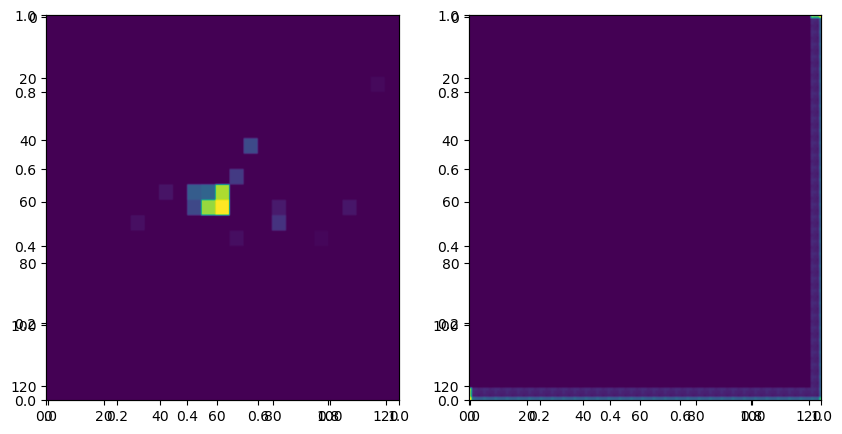

In [ ]:
rows = 1
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize = (10,5))
fig.add_subplot(rows, cols, 1)
plt.imshow(x[0][2], aspect='auto')
fig.add_subplot(rows, cols, 2)
plt.imshow(x_hat[0][2].detach().numpy().reshape(125, 125), aspect='auto')
plt.show()